In [65]:
import torch
import torch.nn.functional as F

import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import cv2
import matplotlib.pyplot as plt

from fpnssd.dataset import SSDDataset


%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [66]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
net = torch.load('models/SSDTest/best.pt').cuda()
net.eval()

SSD(
  (feature_extractor): ResNetFPN(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inpla

In [4]:
from fpnssd.albumentations import (
    ToGray, Resize, ToTensor, Normalize, BBoxesToCoords, ChannelShuffle,
    CLAHE, Blur, HueSaturationValue, ShiftScaleRotate, CoordsToBBoxes,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAASharpen, IAAEmboss,
    RandomContrast, RandomBrightness, OneOf, Compose, ToAbsoluteCoords
)

In [5]:
test_transform = Compose([
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToAbsoluteCoords(),
    Resize(min_dim=512, max_dim=512),
    ToTensor()
], p=1.0)

In [6]:
from collections import defaultdict

In [7]:
from fpnssd.config import read_config

In [8]:
config = read_config("configs/symbol.yml")

In [9]:
from fpnssd.visualization import display_instances

In [10]:
def split_samples(samples, folds,val_fold ):
    with open(samples) as stream:
        samples = json.load(stream)

    folds = pd.read_csv(folds, index_col='ids').T.to_dict()
    train_samples = []
    val_samples = []
    for sample in samples:
        _id = sample['id']
        if _id in folds:
            if folds[_id]['fold'] == val_fold:
                val_samples.append(sample)
            else:
                train_samples.append(sample)
    return train_samples, val_samples

In [11]:
train_samples, val_samples = split_samples(
    "symbol_samples.json", "../dbrain-ocr-passport/amirassov/folds_v1.csv", 0)

In [12]:
dataset = SSDDataset(config['class2label'], val_samples, test_transform)

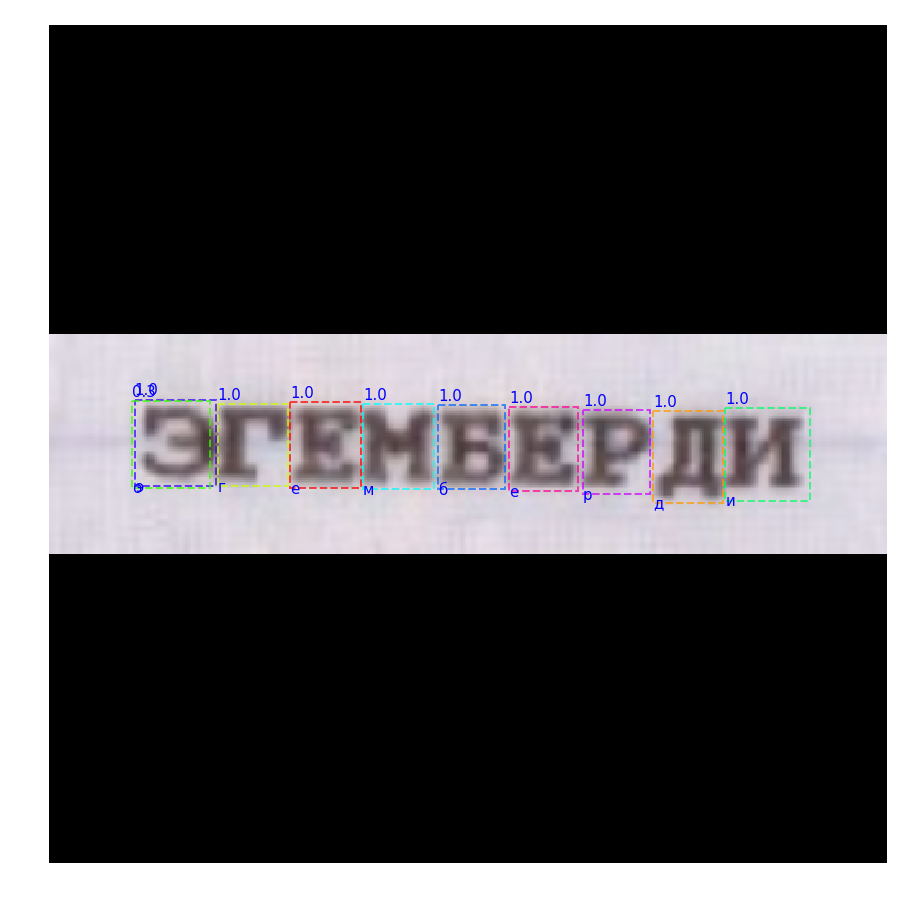

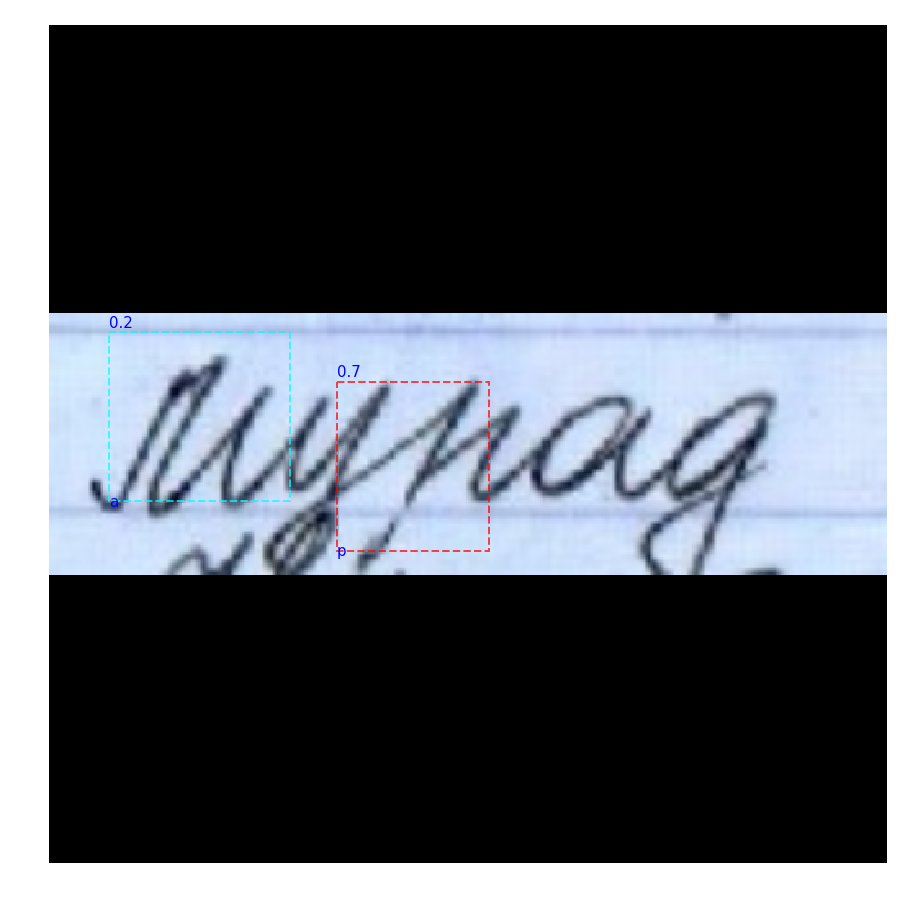

/home/amirassov/fpnssd/fpnssd/bboxer/functional.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  i = order[0]


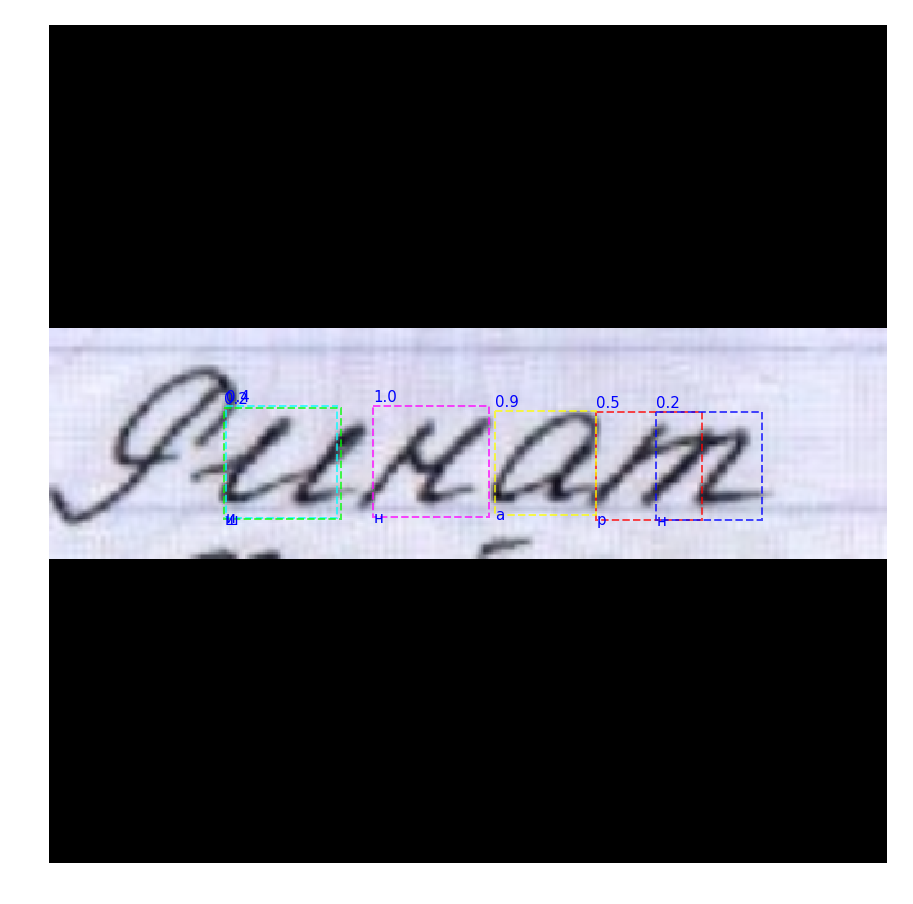

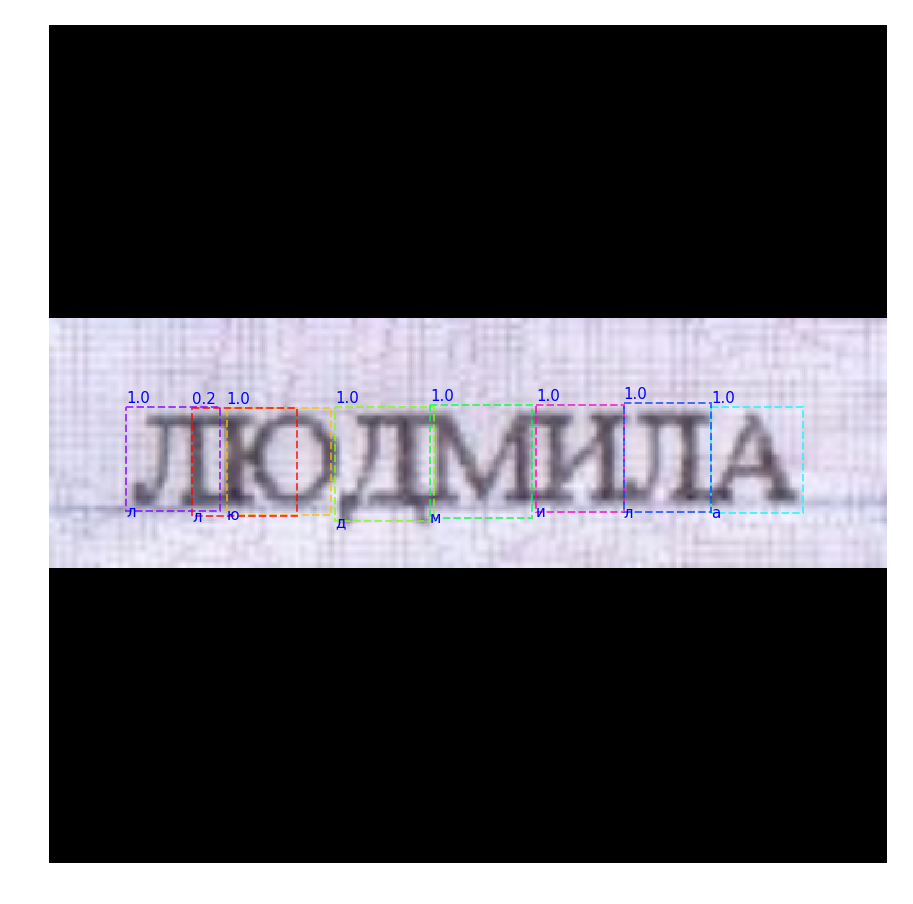

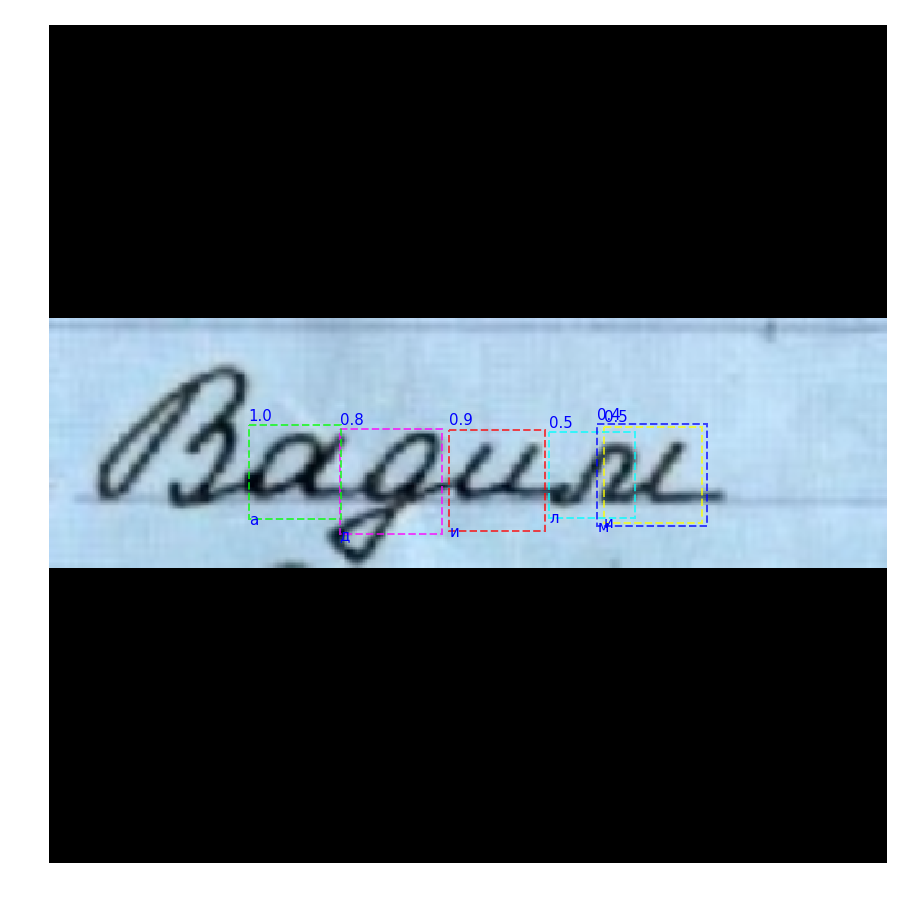

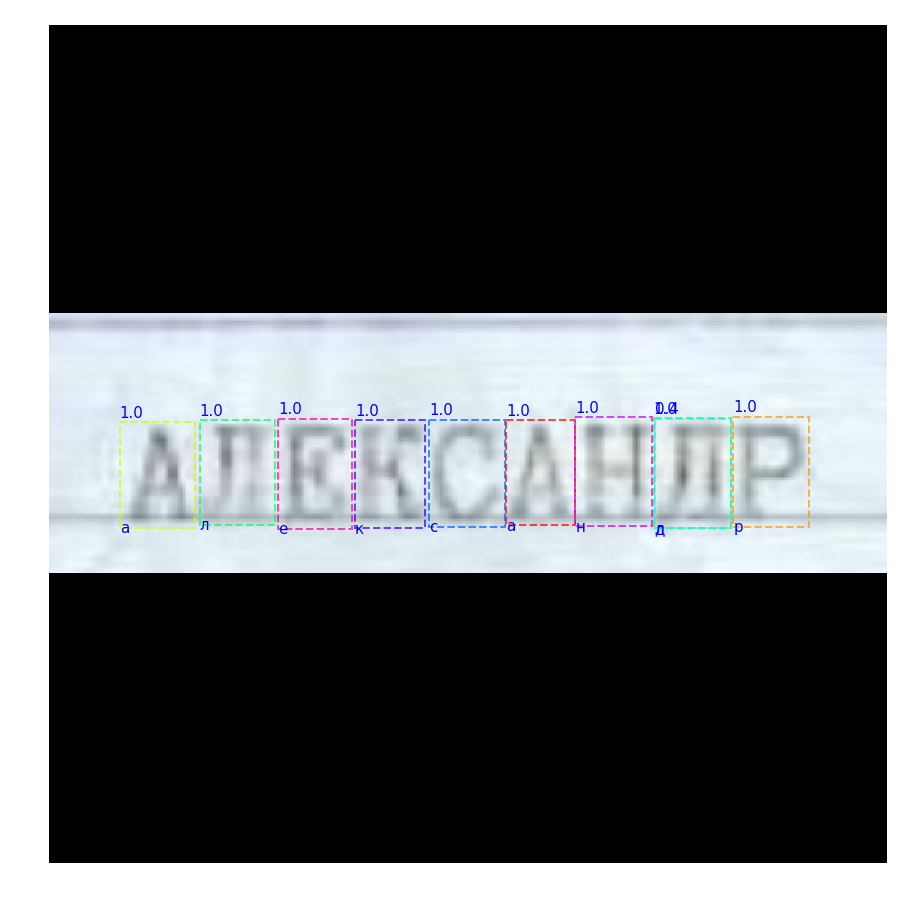

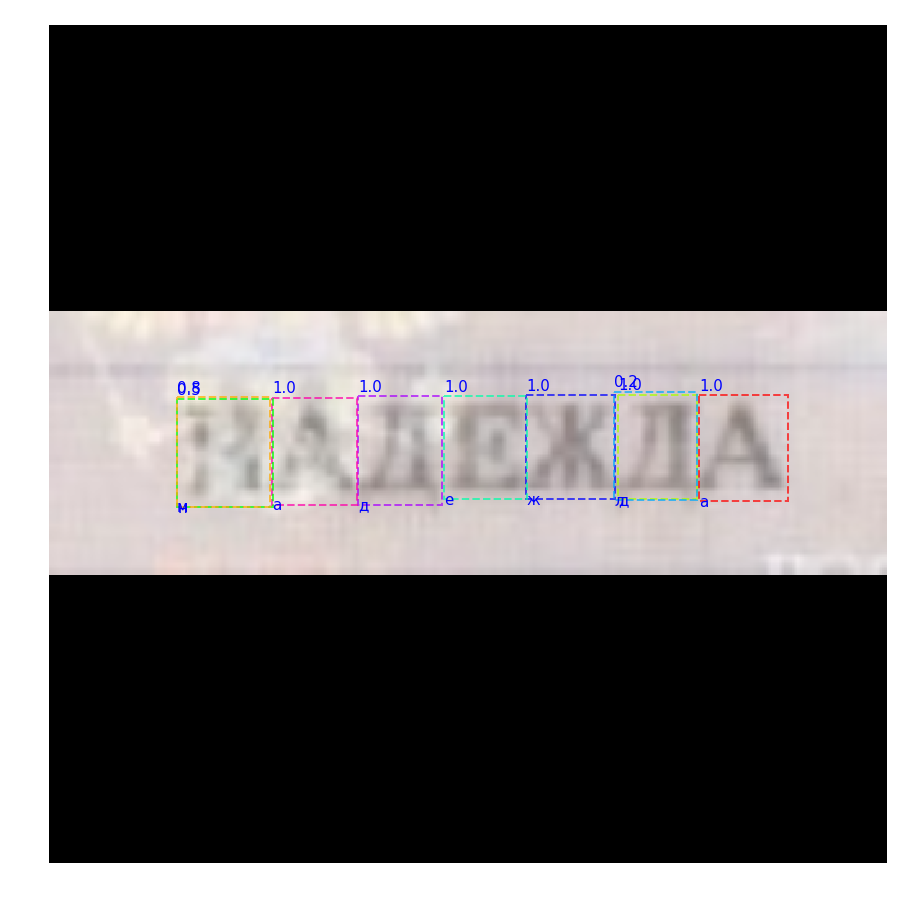

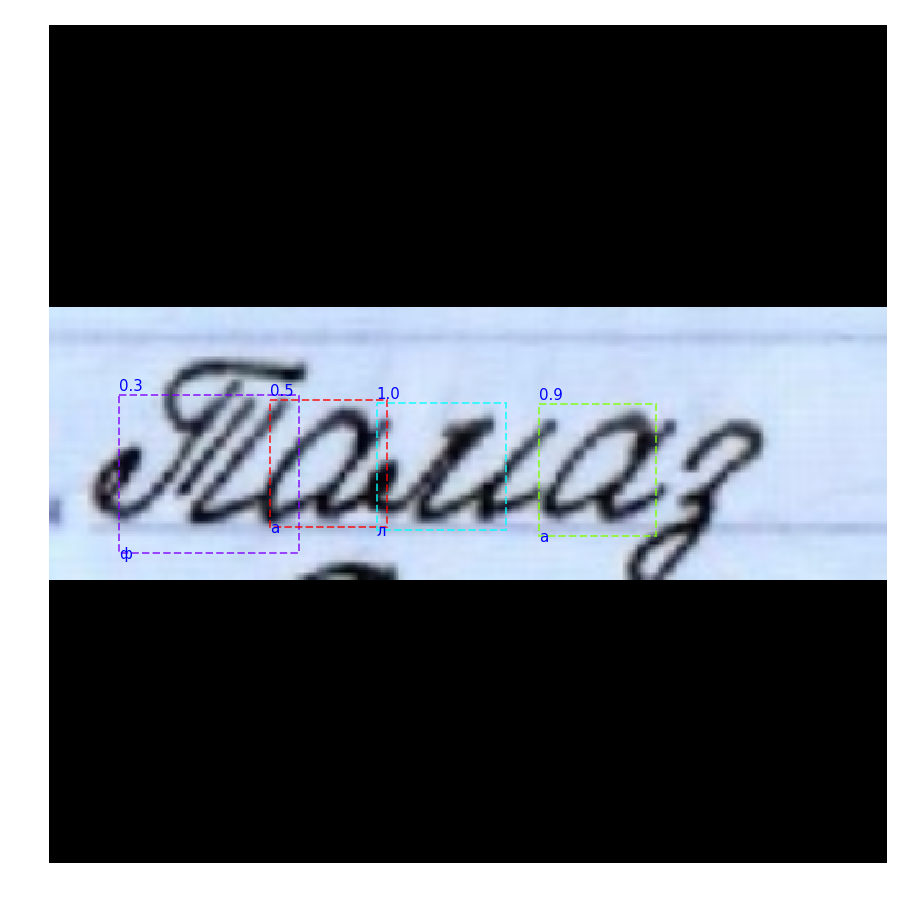

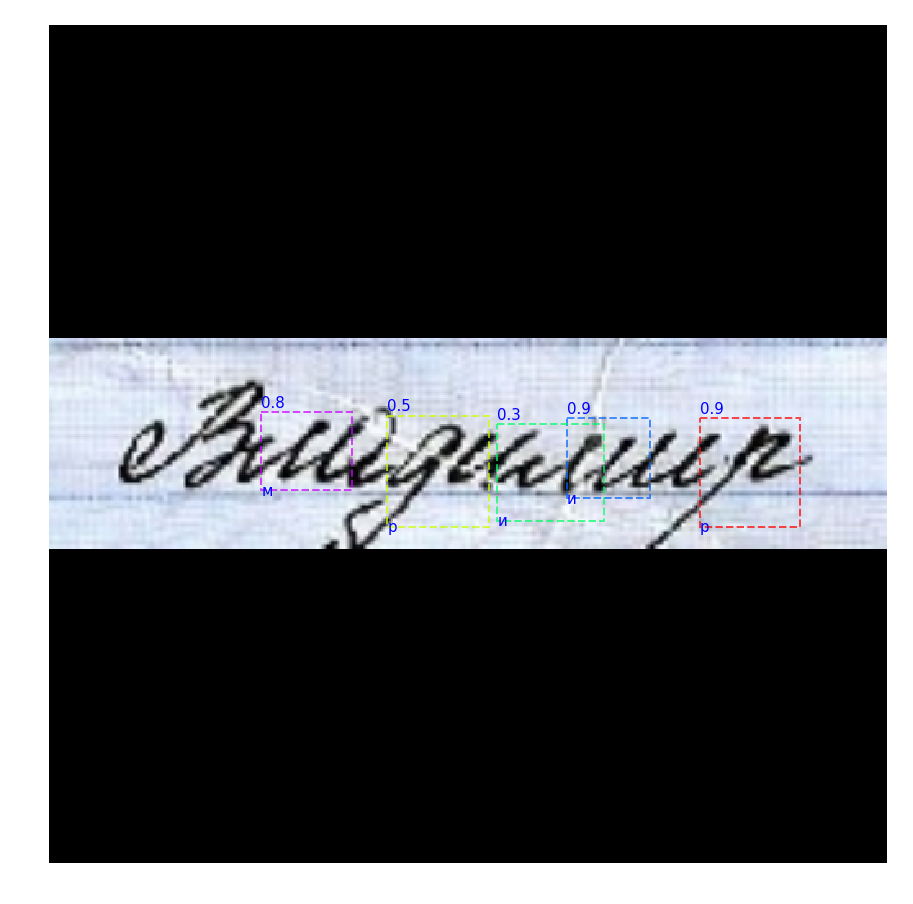

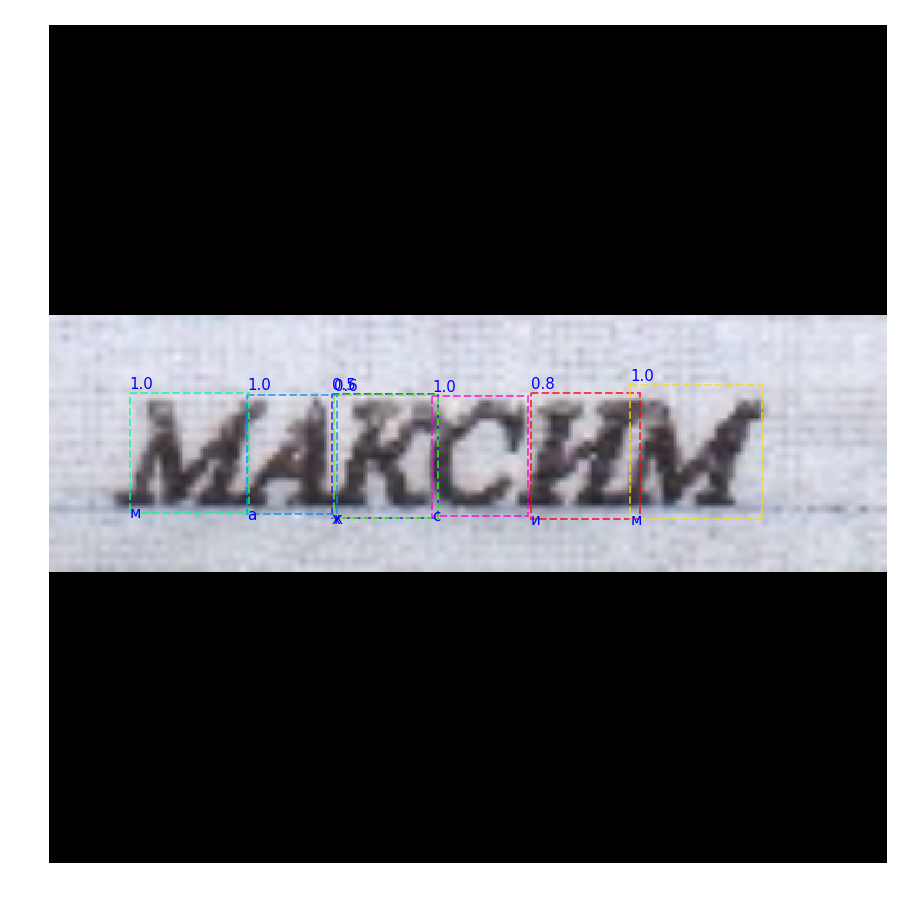

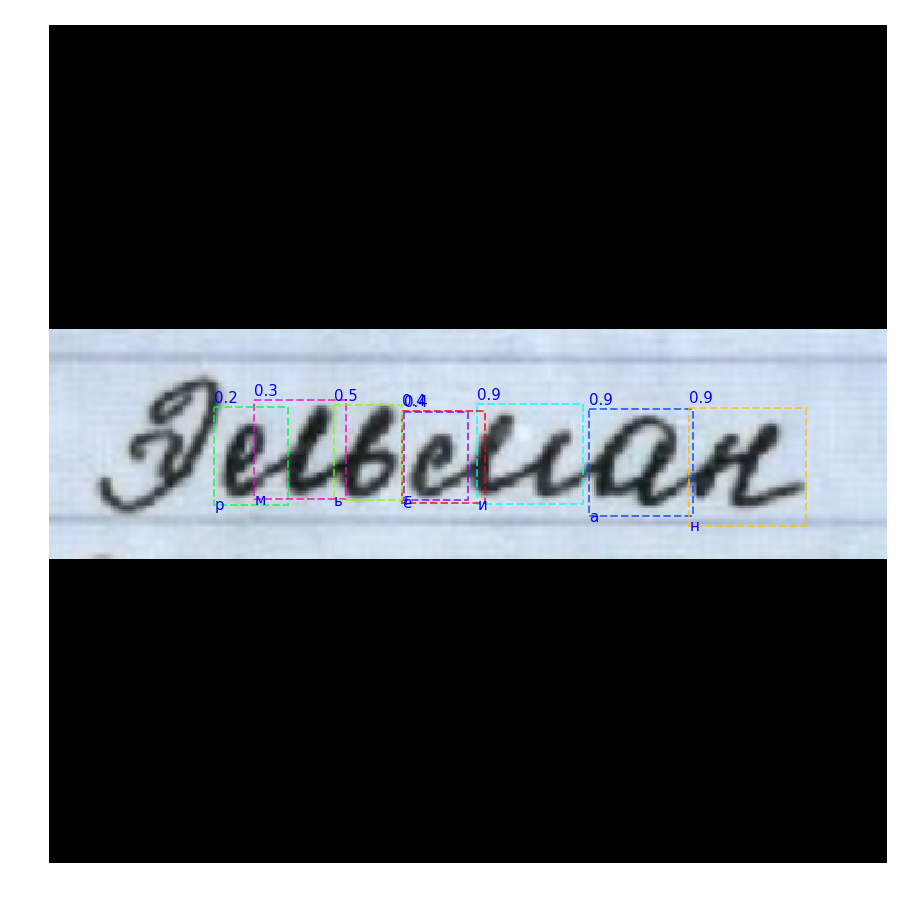

In [ ]:
errors = []
class2label = net.class2label
label2class = dict(zip(class2label.values(), class2label.keys()))

for i in tqdm_notebook(range(len(dataset))):
    net.bboxer.decoder.score_threshold = 0.2
    net.bboxer.decoder.nms_threshold = 0.2

    x = dataset[i]['image'].unsqueeze(0).cuda()
    feature_maps = net.feature_extractor(x)
    multi_bboxes, multi_labels = net.header(feature_maps)
    multi_bboxes = multi_bboxes.cpu()[0]
    multi_labels = multi_labels.cpu()[0].exp().permute(1, 0)
    answer = net.bboxer.decoder(bboxes=multi_bboxes, labels=multi_labels)

    bboxes = answer['bboxes'].data.numpy()
    scores = answer['scores'].data.numpy()
    labels = answer['labels'].data.numpy()
    errors.append(len(labels) - len(dataset[i]['labels']))
    
    if errors[-1]:
        bboxes = answer['bboxes'].data.numpy()
        scores = answer['scores'].data.numpy()
        labels = answer['labels'].data.numpy()
        classes = [label2class[x] for x in labels]
        image = Resize(512, 512)(image=cv2.imread(val_samples[i]['filepath']))['image']
        display_instances(image, bboxes, classes=classes, scores=scores)
        plt.show()
    # class2label = net.class2label
    # label2class = dict(zip(class2label.values(), class2label.keys()))

In [21]:
np.argsort(errors)

array([225, 148, 226, 485, 629, 492, 414, 441, 569, 568, 566, 565, 564,
       563, 562, 567, 570,   0, 572, 561, 573, 574, 575, 576, 577, 578,
       579, 571, 560, 557, 558, 535, 536, 537, 538, 539, 540, 541, 542,
       544, 545, 559, 546, 548, 549, 550, 551, 552, 553, 554, 555, 556,
       580, 547, 581, 584, 583, 610, 611, 612, 613, 614, 615, 616, 617,
       618, 619, 609, 620, 622, 623, 624, 625, 626, 627, 628, 630, 631,
       632, 621, 582, 608, 606, 534, 585, 586, 587, 588, 589, 590, 591,
       592, 593, 607, 594, 596, 597, 598, 599, 600, 601, 602, 603, 604,
       605, 595, 533, 531, 633, 455, 456, 457, 458, 459, 460, 461, 462,
       463, 464, 454, 465, 467, 468, 469, 470, 471, 472, 473, 474, 475,
       476, 466, 477, 453, 451, 426, 427, 428, 429, 431, 432, 433, 434,
       435, 436, 452, 437, 440, 442, 443, 444, 445, 446, 447, 448, 449,
       450, 438, 532, 478, 480, 509, 510, 511, 512, 513, 514, 515, 516,
       517, 518, 508, 519, 521, 522, 523, 524, 525, 526, 527, 52

In [22]:
np.sort(errors)

array([-2, -2, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [19]:
path = "/mnt/hdd1/dataset/passport_clean/fields5/issuing_authority/crp_453509.jpg"

In [20]:
image = Resize(512, 512)(image=cv2.imread(path))['image']

In [21]:
timage = test_transform(image=cv2.imread(path))['image']

In [22]:
net.bboxer.decoder.score_threshold = 0.2
net.bboxer.decoder.nms_threshold = 0.2

x = timage.unsqueeze(0).cuda()
feature_maps = net.feature_extractor(x)
multi_bboxes, multi_labels = net.header(feature_maps)
multi_bboxes = multi_bboxes.cpu()[0]
multi_labels = multi_labels.cpu()[0].exp().permute(1, 0)
answer = net.bboxer.decoder(bboxes=multi_bboxes, labels=multi_labels)

bboxes = answer['bboxes'].data.numpy()
scores = answer['scores'].data.numpy()
labels = answer['labels'].data.numpy()
class2label = net.class2label
label2class = dict(zip(class2label.values(), class2label.keys()))

/home/amirassov/fpnssd/fpnssd/bboxer/functional.py:116: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  i = order[0]


In [17]:
sample = dataset[i]

NameError: name 'i' is not defined

In [68]:
a = torch.Tensor([1,2])

In [23]:
scores

array([0.2465978 , 0.33073372, 0.29051685, 0.6068415 , 0.4524645 ,
       0.34530866, 0.5940609 , 0.50045186, 0.39610094, 0.20460364,
       0.5437659 , 0.38355738, 0.2842218 , 0.25830662, 0.20922743,
       0.23833272, 0.52927244, 0.26759905, 0.55512285, 0.5250879 ,
       0.2099955 , 0.20571104, 0.21155168, 0.5436321 , 0.53587675,
       0.44450727, 0.3584521 , 0.32405636, 0.2592471 , 0.2481951 ,
       0.22154228, 0.31651613, 0.30791542, 0.2658281 , 0.24980755,
       0.9341978 , 0.8998665 , 0.67795604, 0.56497306, 0.539006  ,
       0.282972  , 0.24443308, 0.23440121, 0.5733519 , 0.30027556,
       0.27960002, 0.24193485, 0.200082  ], dtype=float32)

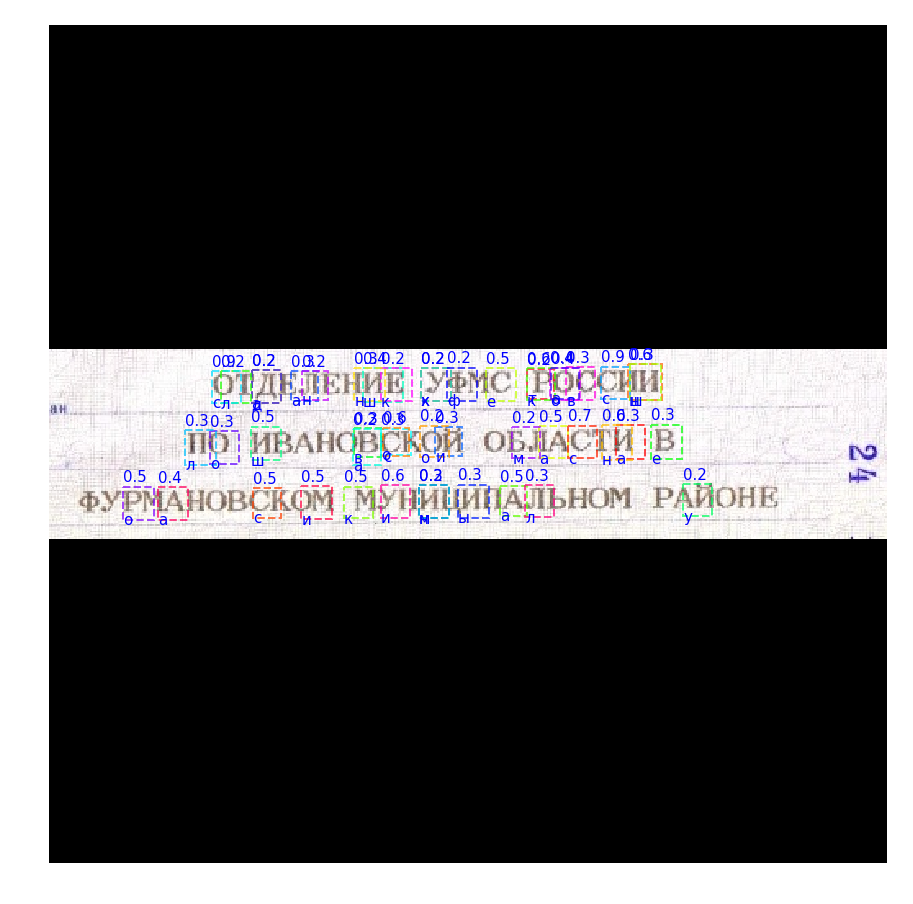

In [25]:
classes = [label2class[x] for x in labels]
display_instances(image, bboxes, classes=classes, scores=scores)

<Figure size 1440x720 with 0 Axes>

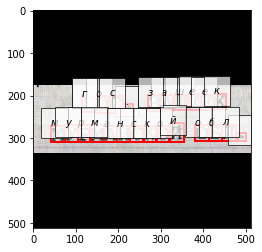

In [57]:
vis_image(image, bboxes, label_names=[label2class[x] for x in labels])

In [43]:
len(sample['bboxes']), len(bboxes)

(25, 33)

In [30]:
50 * 100

5000

In [24]:
samples = json.load(open("../dbrain-ocr-passport/amirassov/symbol_samples.json"))
df = pd.DataFrame(samples)
classes = set(list(''.join(df['text'].str.replace(' ', '').str.lower())))
# class2label = dict(zip(classes, np.arange(len(classes))))

In [43]:
ssd_samples = []
for i, row in tqdm_notebook(df.iterrows(), total=len(df)):
    sample = row.to_dict()
    for i, obj in enumerate(sample['objs']):
        sample['objs'][i]['class'] = 'object'
    ssd_samples.append(sample)

In [25]:
print(classes)

{'.', 'х', 'ю', 'в', 'ч', 'р', 'и', 'п', 'ш', 'т', 'я', 'э', 'о', 'ж', 'б', 'д', 'ц', 'е', '-', 'к', 'г', 'ф', 'а', 'й', '6', 'ы', 'ё', 'л', '9', 'ъ', 'з', '0', 'с', '1', 'м', 'у', ',', 'н', 'щ', 'ь'}


In [26]:
json.dump(samples, open("symbol_samples.json", mode='w'))

In [25]:
ssd_samples

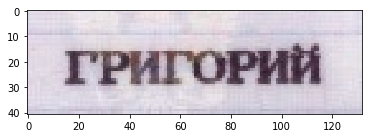

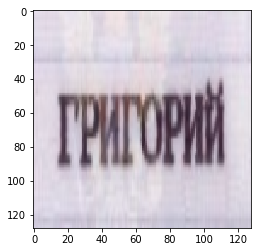

In [33]:

image = cv2.imread(samples[0]['filepath'])
plt.imshow(image)
plt.show()
plt.imshow(cv2.resize(image, (128, 128)))

In [19]:
classes = []
for sample in samples:
    classes.extend([x['label'] for x in sample['objs']])

In [24]:
max(sorted(set(classes)))

40.0

In [9]:
row['filepath']

'/home/amirassov/project-ocr/fields5/first_name/crp_453389.jpg'

In [10]:
row

filepath      /home/amirassov/project-ocr/fields5/first_name...
id                                                       453389
objs          [{'left': 0.10860558712121213, 'right': 0.2110...
resolution                                  {'h': 41, 'w': 132}
text                                                   ГРИГОРИЙ
type                                                 first_name
Name: 0, dtype: object

In [4]:
from torchcv.datasets import JsonDataset

In [20]:
dataset = JsonDataset(filepath='ssd_samples.json')